In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 운영 체제 정보를 확인하고, matplotlib을 사용하여 그래프 그릴 준비하기
import platform
import matplotlib.pyplot as plt

%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"

from matplotlib import font_manager, rc
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Sorry')

plt.rcParams['axes.unicode_minus'] = False

In [2]:
import tensorflow as tf

In [3]:
import pandas as pd
from pathlib import Path

df = pd.read_csv("C:/Users/niceq/Documents/DataScience/Hands_ML/Data/15. cta-ridership-daily-boarding-totals.csv", parse_dates=['service_date'])
df.columns = ['date', 'day_type', 'bus', 'rail', 'total'] # 짧은 이름
df = df.sort_values('date').set_index('date')
df = df.drop('total', axis=1) # total = bus + rail
df = df.drop_duplicates() # 중복 월 삭제

# 모든 열을 숫자형으로 변환
df['bus'] = pd.to_numeric(df['bus'], errors='coerce')
df['rail'] = pd.to_numeric(df['rail'], errors='coerce')

# NaN 값 처리 (필요한 경우)
df = df.fillna(method='ffill').fillna(method='bfill')

df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


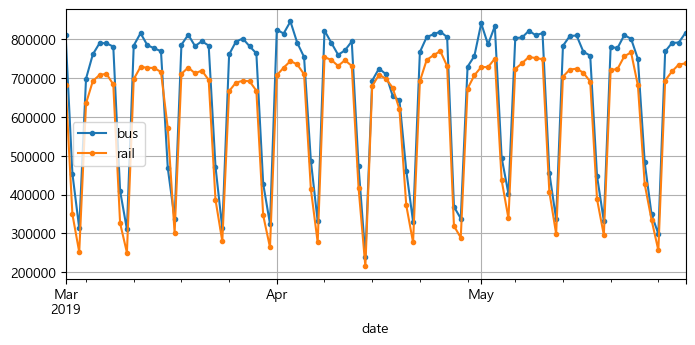

In [4]:
df['2019-03':'2019-05'].plot(grid=True, marker='.', figsize=(8, 3.5))
plt.show()

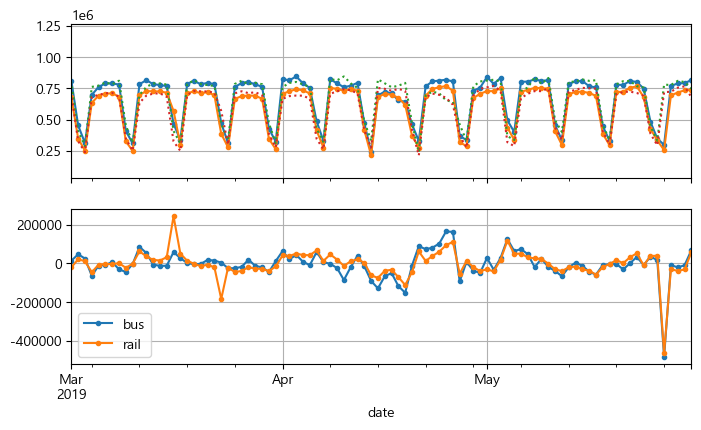

In [5]:
diff_7 = df[['bus', 'rail']].diff(7)['2019-03':'2019-05']

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker='.') # 원본 시계열
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=':') # 지연된 시계열
diff_7.plot(ax=axs[1], grid=True, marker='.') # 7일간의 차이
plt.show()

In [6]:
list(df.loc['2019-05-25':'2019-05-27']['day_type'])

['A', 'U', 'U']

In [7]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [8]:
targets = df[['bus','rail']]['2019-03':'2019-05']
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6755 entries, 2001-01-01 00:00:00 to 2019-06-30 00:00:00
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   day_type  6755 non-null   object
 1   bus       6755 non-null   int64 
 2   rail      6755 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 469.1+ KB


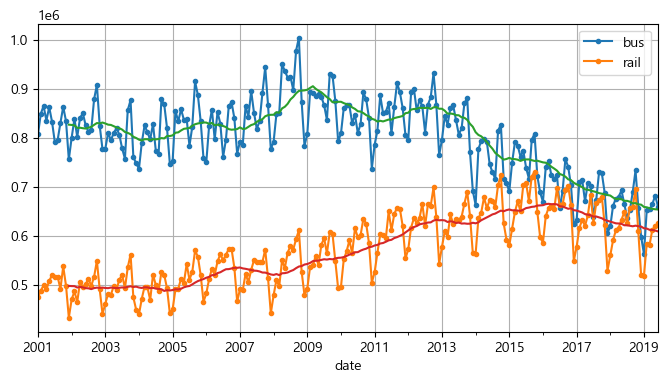

In [10]:
# 기간 설정
period = slice('2001', '2019')

# 숫자형 변수들만 따로 추출
df_numeric = df[['bus', 'rail']]

# 데이터프레임을 월간 평균으로 리샘플링
df_monthly = df_numeric.resample('M').mean()

# 12개월 이동 평균 계산
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

# 시각화
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker='.')
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

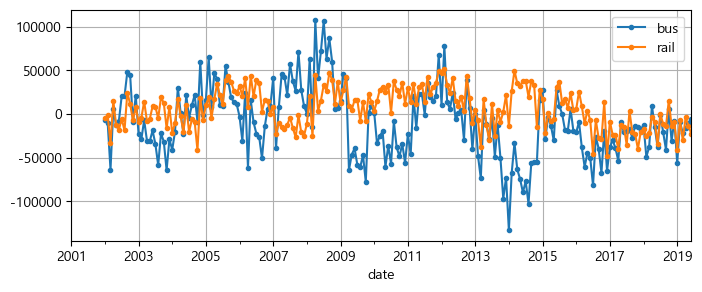

In [11]:
df_monthly.diff(12)[period].plot(grid=True, marker='.', figsize=(8, 3))
plt.show()

In [12]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = '2019-01-01', '2019-05-31'
rail_series = df.loc[origin:today]['rail'].asfreq('D')
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()
y_pred

2019-06-01    427758.626286
Freq: D, dtype: float64

In [13]:
df.loc['2019-06-01']

,day_type,bus,rail
date,,,
2019-06-01,A,473204,379044


In [14]:
origin, start_date, end_date = '2019-01-01', '2019-03-01', '2019-05-31'
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]['rail'].asfreq('D')
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today], # today까지 데이터로 훈련
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit() # 매일 모델 재훈련
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae

32040.720102669347

In [15]:
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:], # 네 번째 원소부터 타깃
    sequence_length=3,
    batch_size=2
)

# 데이터셋의 내용 확인
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

In [16]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f'{element}', end=' ' )
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [17]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f'{window_tensor}')

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [18]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [19]:
dataset = to_windows(tf.data.Dataset.range(6), 4) # 입력 3개 + 타깃 1개 = 4
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

In [20]:
rail_train = df['rail']['2016-01':'2018-12'] / 1e6
rail_valid = df['rail']['2019-01':'2019-05'] / 1e6
rail_test = df['rail']['2019-06':] / 1e6

In [21]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [22]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
ealry_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[ealry_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7379 - mae: 1.1601 - val_loss: 0.0650 - val_mae: 0.3437
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0394 - mae: 0.2360 - val_loss: 0.0048 - val_mae: 0.0719
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - mae: 0.1084 - val_loss: 0.0066 - val_mae: 0.0939
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 - mae: 0.0934 - val_loss: 0.0052 - val_mae: 0.0822
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0817 - val_loss: 0.0047 - val_mae: 0.0702
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - mae: 0.0928 - val_loss: 0.0035 - val_mae: 0.0623
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0769 - val_loss: 0.0039 - val_mae: 0.0682
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0751 - val_loss: 0.0040 - val_mae: 0.0639
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.006

최종 검증 MAE: 0.038124650716781616


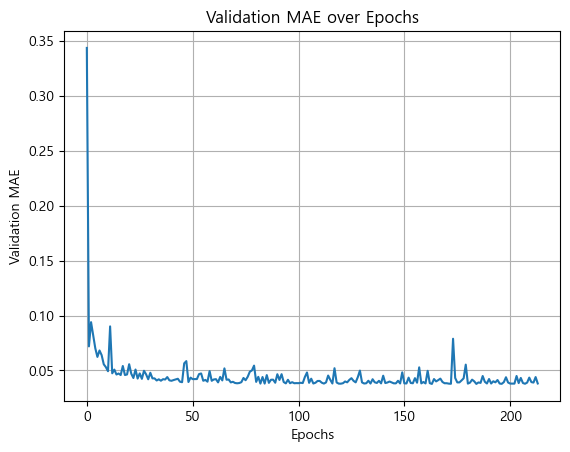

In [23]:
# 훈련 과정에서 수집된 검증 MAE 값을 조회
val_mae_history = history.history['val_mae']

# 마지막 에포크에서의 검증 MAE 값 확인
final_val_mae = val_mae_history[-1]
print(f"최종 검증 MAE: {final_val_mae}")

# 검증 MAE 값의 변화를 시각화
plt.plot(val_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.title('Validation MAE over Epochs')
plt.grid(True)
plt.show()

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0750 - mae: 0.2968 - val_loss: 0.0276 - val_mae: 0.1480
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - mae: 0.1635 - val_loss: 0.0194 - val_mae: 0.1400
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0195 - mae: 0.1637 - val_loss: 0.0182 - val_mae: 0.1433
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0190 - mae: 0.1679 - val_loss: 0.0184 - val_mae: 0.1361
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - mae: 0.1609 - val_loss: 0.0171 - val_mae: 0.1420
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - mae: 0.1642 - val_loss: 0.0167 - val_mae: 0.1412
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0171 - mae: 0.1619 - val_loss: 0.0164 - val_mae: 0.1403
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171 - mae: 0.1623 - val_loss: 0.0161 - val_mae: 0.1391
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.01

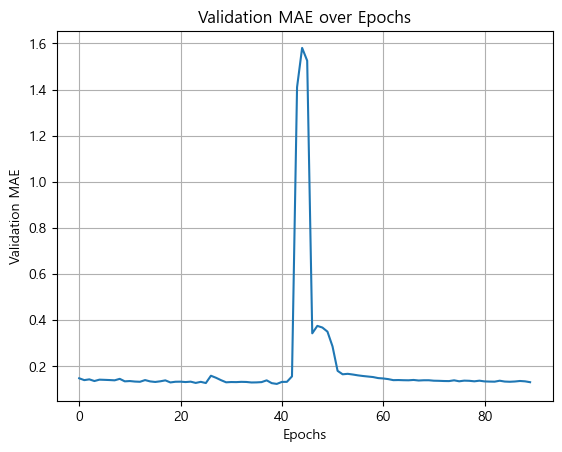

In [24]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
ealry_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[ealry_stopping_cb])

val_mae_history = history.history['val_mae']

final_val_mae = val_mae_history[-1]
print(f"최종 검증 MAE: {final_val_mae}")

plt.plot(val_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.title('Validation MAE over Epochs')
plt.grid(True)
plt.show()

In [26]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [27]:
tf.random.set_seed(42)

univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0513 - mae: 0.2279 - val_loss: 0.0053 - val_mae: 0.0865
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - mae: 0.0843 - val_loss: 0.0046 - val_mae: 0.0728
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - mae: 0.0810 - val_loss: 0.0027 - val_mae: 0.0544
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - mae: 0.0693 - val_loss: 0.0064 - val_mae: 0.0928
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - mae: 0.0843 - val_loss: 0.0033 - val_mae: 0.0584
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - mae: 0.0708 - val_loss: 0.0040 - val_mae: 0.0700
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - mae: 0.0683 - val_loss: 0.0025 - val_mae: 0.0464
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - mae: 0.0594 - val_loss: 0.0023 - val_mae: 0.0459
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.00

28533.900156617165

In [28]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1057 - mae: 0.3484 - val_loss: 0.0157 - val_mae: 0.1588
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0200 - mae: 0.1713 - val_loss: 0.0156 - val_mae: 0.1487
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0174 - mae: 0.1640 - val_loss: 0.0180 - val_mae: 0.1845
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0209 - mae: 0.1737 - val_loss: 0.0164 - val_mae: 0.1345
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0165 - mae: 0.1569 - val_loss: 0.0190 - val_mae: 0.1902
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0195 - mae: 0.1654 - val_loss: 0.0182 - val_mae: 0.1219
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0204 - mae: 0.1652 - val_loss: 0.0149 - val_mae: 0.1478
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0196 - mae: 0.1674 - val_loss: 0.0247 - val_mae: 0.1446
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - lo

30823.970213532448

In [29]:
df_mulvar = df[['bus', 'rail']]/1e6
df_mulvar['next_day_type'] = df['day_type'].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar)
df_mulvar

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,False,False,True
2001-01-02,0.780827,0.501952,False,False,True
2001-01-03,0.824923,0.536432,False,False,True
2001-01-04,0.870021,0.550011,False,False,True
2001-01-05,0.890426,0.557917,True,False,False
...,...,...,...,...,...
2019-06-26,0.778502,0.758880,False,False,True
2019-06-27,0.763256,0.757999,False,False,True
2019-06-28,0.742317,0.717591,True,False,False


In [30]:
mulvar_train = df_mulvar['2016-01':'2018-12']
mulvar_valid = df_mulvar['2019-01':'2019-05']
mulvar_test = df_mulvar['2019-06':]

In [31]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype(np.float32),
    targets=mulvar_train["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype(np.float32),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [33]:
tf.random.set_seed(42)

mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0266 - mae: 0.1728 - val_loss: 0.0018 - val_mae: 0.0453
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - mae: 0.0599 - val_loss: 0.0011 - val_mae: 0.0335
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mae: 0.0457 - val_loss: 0.0017 - val_mae: 0.0479
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - mae: 0.0524 - val_loss: 7.9491e-04 - val_mae: 0.0284
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0389 - val_loss: 0.0012 - val_mae: 0.0402
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - mae: 0.0361 - val_loss: 7.9727e-04 - val_mae: 0.0277
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0349 - val_loss: 0.0011 - val_mae: 0.0366
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0385 - val_loss: 7.6750e-04 - val_mae: 0.0277
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

22525.99224448204

In [34]:
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


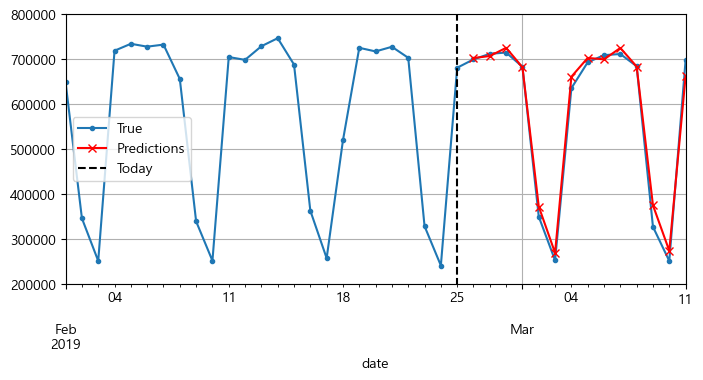

In [35]:
Y_pred = pd.Series(X[0, -14:, 0], index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

In [40]:
tf.random.set_seed(42)

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype(np.float32),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype(np.float32),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [41]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2423 - mae: 0.5704 - val_loss: 0.0250 - val_mae: 0.1732
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0219 - mae: 0.1641 - val_loss: 0.0130 - val_mae: 0.1245
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0141 - mae: 0.1290 - val_loss: 0.0102 - val_mae: 0.1084
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - mae: 0.1164 - val_loss: 0.0079 - val_mae: 0.0964
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - mae: 0.1071 - val_loss: 0.0068 - val_mae: 0.0890
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - mae: 0.1006 - val_loss: 0.0059 - val_mae: 0.0834
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - mae: 0.0948 - val_loss: 0.0051 - val_mae: 0.0769
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - mae: 0.0897 - val_loss: 0.0045 - val_mae: 0.0722
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.00

34288.50695490837

In [42]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length].astype(np.float32)
Y_pred = ahead_model.predict(X)
Y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


array([[0.72013104, 0.72277355, 0.71764934, 0.7066265 , 0.42652714,
        0.2708398 , 0.6595002 , 0.6737622 , 0.68617135, 0.7301199 ,
        0.6990053 , 0.3473756 , 0.26899076, 0.66059947]], dtype=float32)

In [43]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

In [44]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

In [45]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [50]:
# NumPy 배열로 변환
mulvar_train_np = mulvar_train.to_numpy().astype(np.float32)
mulvar_valid_np = mulvar_valid.to_numpy().astype(np.float32)

seq2seq_train = to_seq2seq_dataset(mulvar_train_np, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid_np)

In [51]:
tf.random.set_seed(42)

# 모델 정의 및 컴파일
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1762 - mae: 0.4579 - val_loss: 0.0273 - val_mae: 0.1814
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0219 - mae: 0.1640 - val_loss: 0.0184 - val_mae: 0.1436
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - mae: 0.1389 - val_loss: 0.0150 - val_mae: 0.1297
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0138 - mae: 0.1270 - val_loss: 0.0129 - val_mae: 0.1203
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - mae: 0.1169 - val_loss: 0.0112 - val_mae: 0.1114
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105 - mae: 0.1093 - val_loss: 0.0100 - val_mae: 0.1041
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - mae: 0.1026 - val_loss: 0.0092 - val_mae: 0.0992
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - mae: 0.0972 - val_loss: 0.0084 - val_mae: 0.0940
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.00

48633.27369093895

In [52]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length].astype(np.float32)
Y_pred_14 = seq2seq_model.predict(X)[0, -1] # 마지막 타임 스텝 출력
Y_pred_14

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


array([0.70851713, 0.7077243 , 0.7160418 , 0.69705445, 0.38843006,
       0.27746707, 0.64041173, 0.7082927 , 0.71862406, 0.70081043,
       0.6745427 , 0.40459952, 0.27011812, 0.6731697 ], dtype=float32)

In [56]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)

        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [57]:
tf.random.set_seed(42)
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2599 - mae: 0.5513 - val_loss: 0.0321 - val_mae: 0.1944
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0224 - mae: 0.1723 - val_loss: 0.0202 - val_mae: 0.1499
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0171 - mae: 0.1512 - val_loss: 0.0179 - val_mae: 0.1438
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0155 - mae: 0.1454 - val_loss: 0.0166 - val_mae: 0.1382
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0144 - mae: 0.1401 - val_loss: 0.0155 - val_mae: 0.1333
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0134 - mae: 0.1350 - val_loss: 0.0146 - val_mae: 0.1287
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0127 - mae: 0.1309 - val_loss: 0.0139 - val_mae: 0.1241
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0120 - mae: 0.1261 - val_loss: 0.0131 - val_mae: 0.1200
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - lo

46879.20957803726

In [58]:
tf.random.set_seed(42)
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1525 - mae: 0.4945 - val_loss: 0.0221 - val_mae: 0.1704
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0198 - mae: 0.1613 - val_loss: 0.0197 - val_mae: 0.1485
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0177 - mae: 0.1567 - val_loss: 0.0188 - val_mae: 0.1502
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0174 - mae: 0.1576 - val_loss: 0.0186 - val_mae: 0.1486
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0172 - mae: 0.1563 - val_loss: 0.0184 - val_mae: 0.1477
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0169 - mae: 0.1549 - val_loss: 0.0181 - val_mae: 0.1465
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0167 - mae: 0.1545 - val_loss: 0.0179 - val_mae: 0.1455
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0163 - mae: 0.1525 - val_loss: 0.0177 - val_mae: 0.1447
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - lo

71205.60109615326

In [59]:
tf.random.set_seed(42)
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1686 - mae: 0.5072 - val_loss: 0.0219 - val_mae: 0.1793
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0194 - mae: 0.1628 - val_loss: 0.0192 - val_mae: 0.1441
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0163 - mae: 0.1471 - val_loss: 0.0177 - val_mae: 0.1452
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0157 - mae: 0.1480 - val_loss: 0.0173 - val_mae: 0.1423
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0152 - mae: 0.1446 - val_loss: 0.0168 - val_mae: 0.1398
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0149 - mae: 0.1434 - val_loss: 0.0163 - val_mae: 0.1379
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0144 - mae: 0.1409 - val_loss: 0.0160 - val_mae: 0.1358
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0140 - mae: 0.1387 - val_loss: 0.0156 - val_mae: 0.1340
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - lo

67778.0732512474

In [62]:
tf.random.set_seed(42)
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train_np, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid_np, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid, learning_rate=0.01)

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1890 - mae: 0.5702 - val_loss: 0.0457 - val_mae: 0.2539
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0388 - mae: 0.2298 - val_loss: 0.0197 - val_mae: 0.1570
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0176 - mae: 0.1580 - val_loss: 0.0190 - val_mae: 0.1508
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0168 - mae: 0.1551 - val_loss: 0.0185 - val_mae: 0.1505
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0165 - mae: 0.1545 - val_loss: 0.0182 - val_mae: 0.1492
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0163 - mae: 0.1532 - val_loss: 0.0180 - val_mae: 0.1477
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0160 - mae: 0.1517 - val_loss: 0.0177 - val_mae: 0.1464
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0158 - mae: 0.1505 - val_loss: 0.0175 - val_mae: 0.1450
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - lo

51443.41289997101

In [67]:
tf.random.set_seed(42)
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.Input(shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding='causal', activation="relu", dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

fit_and_evaluate(wavenet_model, longer_train, longer_valid, learning_rate=0.02)

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2020 - mae: 0.6066 - val_loss: 0.0770 - val_mae: 0.3468
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0734 - mae: 0.3379 - val_loss: 0.0239 - val_mae: 0.1940
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0232 - mae: 0.1899 - val_loss: 0.0190 - val_mae: 0.1548
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0164 - mae: 0.1609 - val_loss: 0.0187 - val_mae: 0.1509
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0160 - mae: 0.1589 - val_loss: 0.0187 - val_mae: 0.1501
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158 - mae: 0.1580 - val_loss: 0.0187 - val_mae: 0.1498
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - mae: 0.1579 - val_loss: 0.0186 - val_mae: 0.1496
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0158 - mae: 0.1576 - val_loss: 0.0186 - val_mae: 0.1492
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

51029.77529168129